In [1]:
import os
import random 
from glob import glob 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm 
import json
import pandas as pd
from scipy.stats import norm

from poreUtils import *

In [2]:
# Directory where the scans are stored with results 
root_dir = 'E:\\Data\\sam_data\\new\\'

In [3]:
# Getting the scans where porespy analysis has been run 
scans = []
for p in os.listdir(root_dir):
    file_path = os.path.join(root_dir, p, 'porespy')
    if os.path.exists(file_path):
        scans.append(p)

In [4]:
# geting the group information
df = pd.read_csv('study_group.csv')
df

,Identification,Group,ImgBL,ImgVILI,Sample,Scan
0,Rat1,Con-VILI,1,1,MD_1264_A1,MD_1264_A1_1_Z0.0mm
1,Rat1,Con-VILI,1,1,MD_1264_A1,MD_1264_A1_1_Z3.3mm
2,Rat1,Con-VILI,1,1,MD_1264_A1,MD_1264_A1_1_Z6.6mm
3,Rat1,Con-VILI,1,1,MD_1264_A1,MD_1264_A1_1_Z9.9mm
4,Rat1,Con-VILI,1,1,MD_1264_A1,MD_1264_A1_1_Z13.2mm
...,...,...,...,...,...,...
75,Rat10,Con-VILI,1,1,MD_1264_B10,MD_1264_B10_Z0.0mm
76,Rat10,Con-VILI,1,1,MD_1264_B10,MD_1264_B10_Z3.3mm
77,Rat19,Con,1,0,MD_1264_A19,19A_2_Z0.0mm
78,Rat19,Con,1,0,MD_1264_A19,19A_2_Z3.3mm_corr_phrt


In [5]:
# creating diffrent groups from the available scans
scan_groups = {}
for g in np.unique(df['Group']):
    scan_groups[g] = []

for scan in scans:
    scan_index = df.loc[df['Scan'] == str(scan)].index[0]
    group = df['Group'][scan_index]
    scan_groups[group].append(scan)

print(scan_groups)

{'Ble': ['MD_1264_A11_Z3.3mm_corr_phrt', 'MD_1264_A18', 'MD_1264_A3_1_Z3.3mm', 'MD_1264_A6_1_Z3.3mm_corr_phrt', 'MD_1264_B3_1_Z3.3mm'], 'Ble-VILI': ['MD_1264_A12_Z3.3mm_corr_phrt', 'MD_1264_A2_1_Z3.3mm', 'MD_1264_A5_1_Z0.0mm_corr_phrt', 'MD_1264_A9_Z0.0mm_Z3.3mm', 'MD_1264_B2_1', 'MD_1264_B5_1_Z3.3mm', 'MD_1264_B9_Z3.3mm'], 'Con': ['19A_2_Z0.0mm', '19A_2_Z13.2mm', '19A_2_Z3.3mm_corr_phrt'], 'Con-VILI': ['MD_1264_A10_Z6.6mm', 'MD_1264_A13_1_Z3.3mm_corr_phrt', 'MD_1264_A16_Z3.3mm_corr_phrt', 'MD_1264_A1_1_Z3.3mm', 'MD_1264_A4_1_Z0.0mm_Z3.3mm_corr_phrt', 'MD_1264_B10_Z0.0mm', 'MD_1264_B10_Z3.3mm', 'MD_1264_B4_1_Z3.3mm']}


In [6]:
def ratio_greater_than_threshold(lst, threshold, start=None, end=None):
    """
    Calculate the ratio of values in a list that are greater than a specified threshold.

    Args:
        lst (list): The list of numbers.
        threshold (float): The threshold value to compare each element against.
        start (float): The starting value of the range to consider. Defaults to None, which means
                       start at the beginning of the list.
        end (float): The ending value of the range to consider. Defaults to None, which means
                     end at the end of the list.

    Returns:
        float: The ratio of values in the specified range of the list that are greater than the threshold.
    """
    if start is None:
        start = lst[0]
    if end is None:
        end = lst[-1]

    start_index = lst.index(start) if start in lst else None
    end_index = lst.index(end) if end in lst else None

    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(lst)

    count_greater = sum(1 for x in lst[start_index:end_index] if x > threshold)
    count_total = end_index - start_index

    return count_greater / count_total if count_total > 0 else 0.0

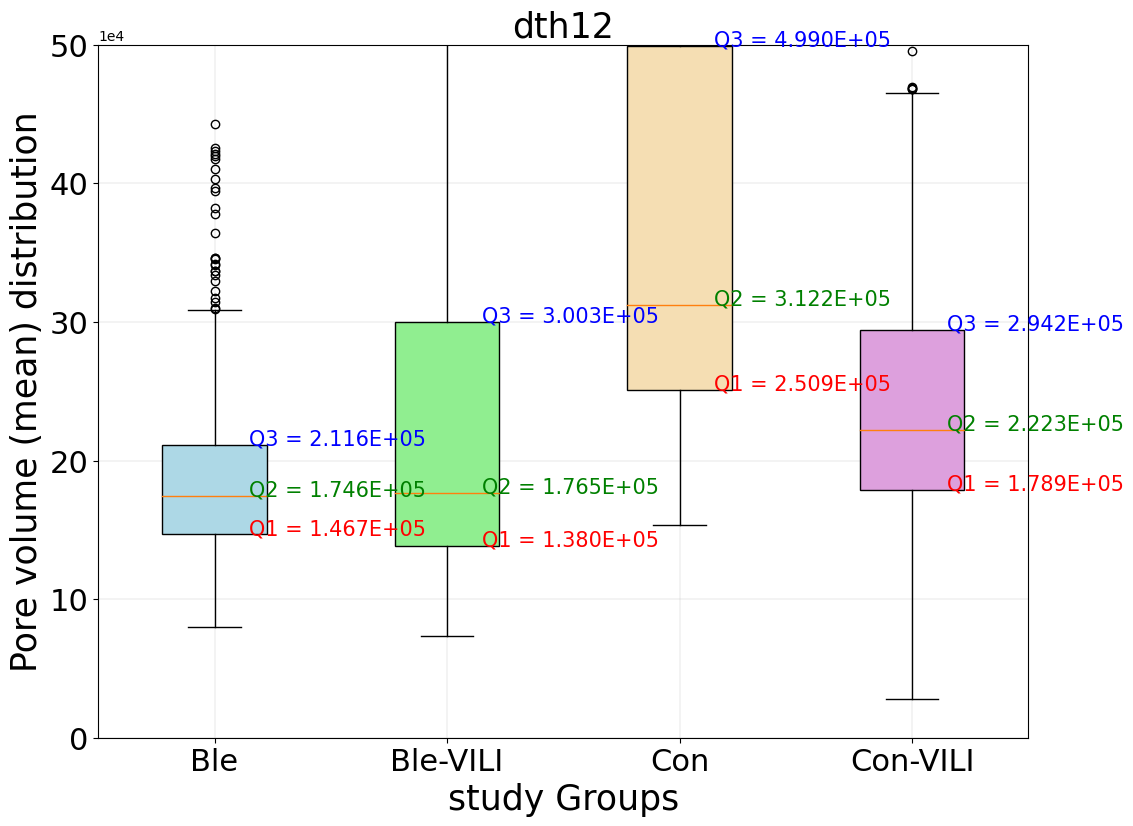

In [16]:
parameter_per_group = []
for key in scan_groups.keys():
    json_files = []
    for aFile in scan_groups[key]:
        fpath = os.path.join(root_dir, aFile, 'porespy')
        json_files += glob(fpath + '\*' + 'dth12' + '.json')

    parameter = []
    for json_file in json_files:
        file = open(json_file)
        data = json.load(file)
        file.close()
        extract_feature = data['volume']

        #
        # do what we want to plot for exampe, blob volume
        #
        if len(extract_feature) > 0:
            # parameter += extract_feature
            parameter.append(np.mean(extract_feature))
            # parameter.append(ratio_greater_than_threshold(extract_feature, 100000))

    parameter_per_group.append([key, parameter]) 

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12,9))

# Create the boxplot
bp = ax.boxplot([x[1] for x in parameter_per_group], patch_artist=True, boxprops=dict(facecolor='lightgray', edgecolor='black'))

# Add color to the boxes
colors = ['lightblue', 'lightgreen', 'wheat', 'plum']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Loop through the boxes and add the quartile values as text
for i, box in enumerate(bp['boxes']):
    # Calculate the quartiles
    q1, q2, q3 = np.percentile([x[1] for x in parameter_per_group][i], [25, 50, 75])
    

    # Add text labels for the quartile values
    ax.text(i+1.15, q1, f'Q1 = {q1:.3E}', color='r', fontsize=15)
    ax.text(i+1.15, q2, f'Q2 = {q2:.3E}', color='g', fontsize=15)
    ax.text(i+1.15, q3, f'Q3 = {q3:.3E}', color='b', fontsize=15)

# Add labels and a title to the plot
ax.set_xlabel('study Groups', size=25)
ax.set_ylabel('Pore volume (mean) distribution', size=25)
ax.set_title(('dth12'), size=25)
ax.set_xticklabels([x[0] for x in parameter_per_group])
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_ylim([0.0, 50e4])
# ax.set_xlim([0, 4])
ax.grid(linewidth=0.2)
ax.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
# plt.savefig('Output/new/vol_mean_dth12.svg', facecolor='whitesmoke')

# Display the plot
plt.show()

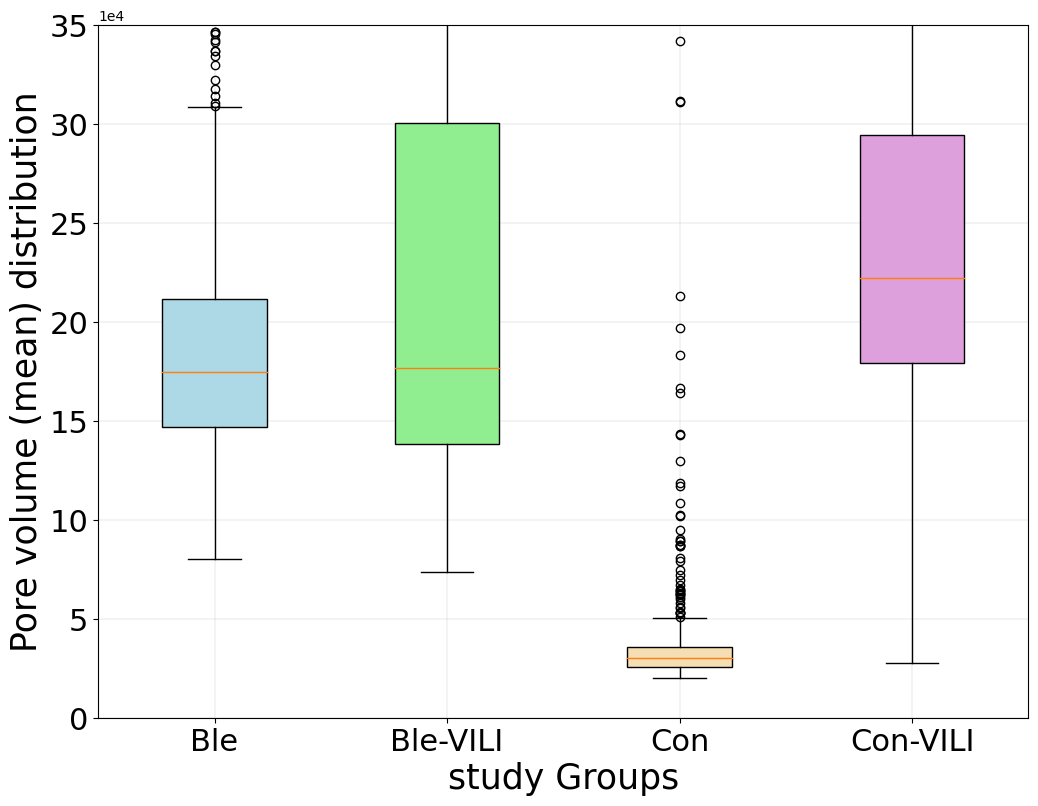

In [41]:
parameter_per_group = []
for key in scan_groups.keys():
    json_files = []
    if key == 'Con':
        for aFile in scan_groups[key]:
            fpath = os.path.join(root_dir, aFile, 'porespy')
            json_files += glob(fpath + '\*' + 'dth8' + '.json')
    else:
        for aFile in scan_groups[key]:
            fpath = os.path.join(root_dir, aFile, 'porespy')
            json_files += glob(fpath + '\*' + 'dth12' + '.json')

    parameter = []
    for json_file in json_files:
        file = open(json_file)
        data = json.load(file)
        file.close()
        extract_feature = data['volume']

        #
        # do what we want to plot for exampe, blob volume
        #
        if len(extract_feature) > 0:
            # parameter += extract_feature
            parameter.append(np.mean(extract_feature))
            # parameter.append(ratio_greater_than_threshold(extract_feature, 100000))

    parameter_per_group.append([key, parameter]) 

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12,9))

# Create the boxplot
bp = ax.boxplot([x[1] for x in parameter_per_group], patch_artist=True, boxprops=dict(facecolor='lightgray', edgecolor='black'))

# Add color to the boxes
colors = ['lightblue', 'lightgreen', 'wheat', 'plum']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Loop through the boxes and add the quartile values as text
for i, box in enumerate(bp['boxes']):
    # Calculate the quartiles
    q1, q2, q3 = np.percentile([x[1] for x in parameter_per_group][i], [25, 50, 75])
    

    # Add text labels for the quartile values
    # ax.text(i+1.15, q1, f'Q1 = {q1:.3E}', color='r', fontsize=15)
    # ax.text(i+1.15, q2, f'Q2 = {q2:.3E}', color='g', fontsize=15)
    # ax.text(i+1.15, q3, f'Q3 = {q3:.3E}', color='b', fontsize=15)

# Add labels and a title to the plot
ax.set_xlabel('study Groups', size=25)
ax.set_ylabel('Pore volume (mean) distribution', size=25)
# ax.set_title(('dth12'), size=25)
ax.set_xticklabels([x[0] for x in parameter_per_group])
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_ylim([0.0, 35e4])
# ax.set_xlim([0, 4])
ax.grid(linewidth=0.2)
ax.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
# plt.savefig('Output/new/vol_mean_dth12.svg', facecolor='whitesmoke')

# Display the plot
plt.show()

In [13]:
for key in scan_groups.keys():
    json_files = []
    if key=='Con':
        for aFile in scan_groups[key]:
            fpath = os.path.join(root_dir, aFile, 'porespy')
            json_files += glob(fpath + '\*' + 'dth8' + '.json')
    else:
        for aFile in scan_groups[key]:
            fpath = os.path.join(root_dir, aFile, 'porespy')
            json_files += glob(fpath + '\*' + 'dth12' + '.json')

In [11]:
json_files = []
for aFile in scan_groups['Con']:
    fpath = os.path.join(root_dir, aFile, 'porespy')
    json_files += glob(fpath + '\*' + 'dth8' + '.json')

In [17]:
len(json_files)

0

In [29]:
json_files = []
for key in scan_groups.keys():
    
    if key == 'Con':
        for aFile in scan_groups[key]:
            fpath = os.path.join(root_dir, aFile, 'porespy')
            json_files += glob(fpath + '\*' + 'dth8' + '.json')

In [27]:
for key in scan_groups.keys():
    json_files = []
    if key == 'Con':
        for aFile in scan_groups[key]:
            fpath = os.path.join(root_dir, aFile, 'porespy')
            json_files += glob(fpath + '\*' + 'dth8' + '.json')
            print(json_files)

['E:\\Data\\sam_data\\new\\19A_2_Z0.0mm\\porespy\\0-300x1000-1300x200-500_bth55_dth8.json', 'E:\\Data\\sam_data\\new\\19A_2_Z0.0mm\\porespy\\0-300x1000-1300x2200-2500_bth55_dth8.json', 'E:\\Data\\sam_data\\new\\19A_2_Z0.0mm\\porespy\\0-300x1000-1300x2400-2700_bth55_dth8.json', 'E:\\Data\\sam_data\\new\\19A_2_Z0.0mm\\porespy\\0-300x1000-1300x400-700_bth55_dth8.json', 'E:\\Data\\sam_data\\new\\19A_2_Z0.0mm\\porespy\\0-300x1000-1300x600-900_bth55_dth8.json', 'E:\\Data\\sam_data\\new\\19A_2_Z0.0mm\\porespy\\0-300x1200-1500x1200-1500_bth55_dth8.json', 'E:\\Data\\sam_data\\new\\19A_2_Z0.0mm\\porespy\\0-300x1200-1500x200-500_bth55_dth8.json', 'E:\\Data\\sam_data\\new\\19A_2_Z0.0mm\\porespy\\0-300x1200-1500x400-700_bth55_dth8.json', 'E:\\Data\\sam_data\\new\\19A_2_Z0.0mm\\porespy\\0-300x1400-1700x1200-1500_bth55_dth8.json', 'E:\\Data\\sam_data\\new\\19A_2_Z0.0mm\\porespy\\0-300x1400-1700x200-500_bth55_dth8.json', 'E:\\Data\\sam_data\\new\\19A_2_Z0.0mm\\porespy\\0-300x1400-1700x400-700_bth55_dt

In [30]:
len(json_files)

496